<a href="https://colab.research.google.com/github/Sharan-Babu/ImageDehazingWithCycleGANs/blob/main/CycleGAN_Night.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-aucyosll
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-aucyosll
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=69c8d9702ccd63bff28bdbf608ba4c0c93c5167b626456dbd6880a3b03858400
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfoox0go/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
cd /content/drive/MyDrive/CycleGAN_Night

/content/drive/MyDrive/CycleGAN_Night


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-3ddfn5ui
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-3ddfn5ui
  Created wheel for tensorflow-examples: filename=tensorflow_examples-9c795bcd8520dc726c87cd699e714f1fbc0226dd_-cp36-none-any.whl size=157167 sha256=6620d1c03b8e375d3262643dcb52f9784d37ede1bd05b94615e9811952090b5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-picjbx2t/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
!git clone https://github.com/vanhuyz/CycleGAN-TensorFlow.git

Cloning into 'CycleGAN-TensorFlow'...
remote: Enumerating objects: 567, done.
remote: Total 567 (delta 0), reused 0 (delta 0), pack-reused 567
Receiving objects: 100% (567/567), 4.17 MiB | 6.42 MiB/s, done.
Resolving deltas: 100% (346/346), done.


In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

def load_images(path, size=(256,256)):
    data_list = list()
    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    return asarray(data_list)

path = '/content/drive/MyDrive/CycleGAN_Night/'
dataA1 = load_images(path + 'night haze(H)/')
dataAB = load_images(path + 'validation/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
dataB1 = load_images(path + 'night real(H)/')
dataB2 = load_images(path + 'clear_test/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
filename = 'dehaze.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (105, 256, 256, 3)
Loaded dataB:  (105, 256, 256, 3)
Saved dataset:  dehaze.npz


Loaded:  (105, 256, 256, 3) (105, 256, 256, 3)


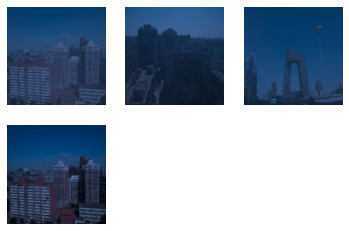

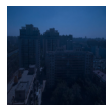

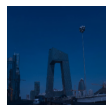

In [ ]:
from numpy import load
from matplotlib import pyplot
data = load('dehaze.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
    pyplot.show()

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

random_normal = RandomNormal(stddev=0.02,mean=0.0)

def define_discriminator(image_shape):
    
    init = RandomNormal(stddev=0.02, mean=0.0)
    in_image = Input(shape=image_shape)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

In [ ]:
image_shape = (256,256,3)
model = define_discriminator(image_shape)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)      

In [ ]:
def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02, mean=0.0)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])
    return g

In [ ]:
def define_generator(image_shape, n_resnet=9):
    init = RandomNormal(stddev=0.02,mean=0.0)
    in_image = Input(shape=image_shape)
    
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    return model       

In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    output_f = g_model_2(gen1_out)
    
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10],
                  optimizer=opt)
    return model

In [ ]:
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [ ]:
c_model_AtoBtoA = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoAtoB = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [ ]:
def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X), patch_shape, patch_shape,1))
    return X,y

In [ ]:
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [ ]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,
dataset):
    n_epochs, n_batch, = 10, 1                              # set epochs only
    n_patch = d_model_A.output_shape[1]
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA,
            X_realA, X_realB, X_realA])
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,
            X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2,
            dB_loss1,dB_loss2, g_loss1,g_loss2))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 1) == 0:                                   
            save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
dataset = load_real_samples('dehaze.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]

g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (105, 256, 256, 3) (105, 256, 256, 3)
>1, dA[0.741,1.105] dB[0.708,1.488] g[20.235,20.006]
>2, dA[3.674,0.962] dB[5.544,4.362] g[23.855,18.857]
>3, dA[14.886,0.688] dB[3.682,5.323] g[25.706,22.361]
>4, dA[14.398,0.508] dB[6.051,10.789] g[23.222,20.923]
>5, dA[3.607,0.637] dB[5.991,2.763] g[22.292,18.767]
>6, dA[1.845,1.071] dB[5.898,2.299] g[19.502,18.905]
>7, dA[0.465,2.470] dB[1.631,0.916] g[17.229,18.292]
>8, dA[0.564,1.054] dB[0.651,1.152] g[17.146,15.956]
>9, dA[0.549,1.841] dB[0.608,0.997] g[15.839,16.898]
>10, dA[0.415,1.385] dB[0.577,0.537] g[15.503,16.049]
>11, dA[0.188,0.645] dB[0.425,0.532] g[14.459,14.748]
>12, dA[0.363,0.380] dB[0.564,1.040] g[14.013,13.898]
>13, dA[0.329,0.419] dB[0.603,0.549] g[13.030,12.867]
>14, dA[0.562,0.317] dB[0.569,0.382] g[13.511,13.404]
>15, dA[0.326,0.359] dB[0.484,0.960] g[11.433,11.426]
>16, dA[0.165,0.347] dB[0.643,0.408] g[13.455,12.702]
>17, dA[0.205,0.460] dB[0.338,0.327] g[11.993,11.459]
>18, dA[0.477,0.306] dB[0.344,0.294] g[15.9

In [ ]:
A_data, B_data = load_real_samples('dehaze.npz')
print('Loaded', A_data.shape, B_data.shape)
cust = {'InstanceNormalization': InstanceNormalization}

Loaded (105, 256, 256, 3) (105, 256, 256, 3)


In [ ]:
from keras.models import load_model
model_AtoB = load_model('g_model_AtoB_000945.h5', cust)
model_BtoA = load_model('g_model_BtoA_001050.h5', cust)

In [ ]:
def select_sample(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    return X

In [ ]:
A_real = select_sample(A_data, 1)
B_generated = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)

In [ ]:
def show_plot(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    images = (images + 1) / 2.0
    for i in range(len(images)):
        pyplot.subplot(1, len(images), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(images[i])
        pyplot.title(titles[i])
    pyplot.show()

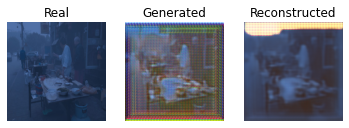

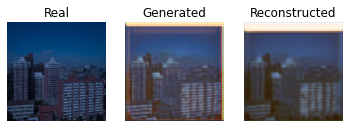

In [ ]:
from numpy import vstack
show_plot(A_real, B_generated, A_reconstructed)    
B_real = select_sample(B_data, 1)
A_generated = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

AtoB


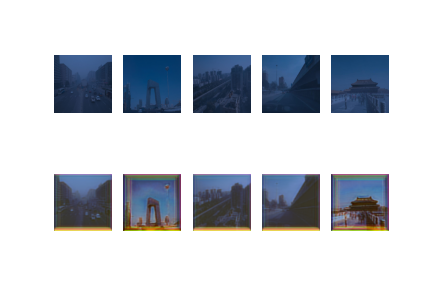

In [ ]:
print("AtoB")
Image('AtoB_generated_plot_001050.png')

BtoA


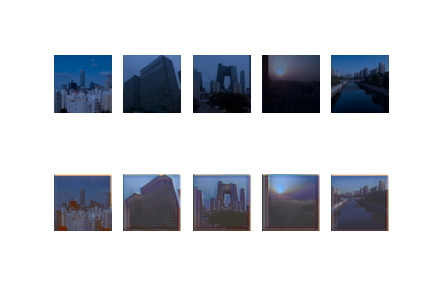

In [ ]:
print("BtoA")
from IPython.display import Image
Image('BtoA_generated_plot_001050.png')
